## Оганян Роберт. Задание по временным рядам

### Загрузка данных

In [1]:
!pip install plotly pandas statsmodels scikit-learn tqdm


[notice] A new release of pip available: 22.2.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests

from plotly import __version__
print(__version__) # need 1.9.0 or greater
init_notebook_mode(connected = True)

5.13.1


In [3]:
import matplotlib.pyplot as plt

In [4]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
     

In [5]:
df = pd.read_csv('./data.csv')
my_data = df[df['ФИО'] == 'Оганян Роберт Владимирович']
title = my_data.Title
index = my_data.index
my_data

ФИО                                Title  \
4  Оганян Роберт Владимирович  Обратные тригонометрические функции   

   2021-02-22  2021-02-23  2021-02-24  2021-02-25  2021-02-26  2021-02-27  \
4         361         442         492         436         350         371   

   2021-02-28  2021-03-01  ...  2023-03-05  2023-03-06  2023-03-07  \
4         413         502  ...         361         412         307   

   2023-03-08  2023-03-09  2023-03-10  2023-03-11  2023-03-12  2023-03-13  \
4         323         441         413         263         411         478   

   2023-03-14  
4         491  

[1 rows x 753 columns]

In [6]:
my_data = my_data.T.iloc[2:]
my_data.reset_index(inplace=True)
my_data.rename(columns={index.to_numpy()[0]:'Views', 'index':'Date'}, inplace=True)
my_data.Date = pd.to_datetime(my_data.Date)
my_data['Views'] = my_data['Views'].astype(int)
my_data

Date  Views
0   2021-02-22    361
1   2021-02-23    442
2   2021-02-24    492
3   2021-02-25    436
4   2021-02-26    350
..         ...    ...
746 2023-03-10    413
747 2023-03-11    263
748 2023-03-12    411
749 2023-03-13    478
750 2023-03-14    491

[751 rows x 2 columns]

Наш ряд имеет следующий вид

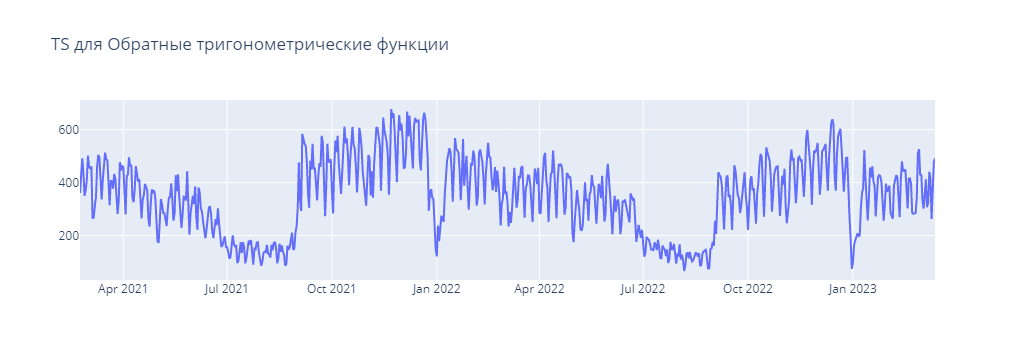

In [7]:
plotly_df(my_data.set_index('Date'), title=f'TS для {str(title.iloc[0])}')

### Обработка аномальности

Выявим аномальные точки с помощью скользящего среднего. Будем использовать *оффлайн* версию (аномальность точки выявляется по всей истории. Онлайн версия - история до заданного момента времени)

In [8]:
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, median_absolute_error,
                             r2_score)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [9]:
def plotMovingAverage(
    series, window, plot_intervals=False, scale=1.96, plot_anomalies=False
):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series < lower_bond] = series[series < lower_bond]
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    return anomalies

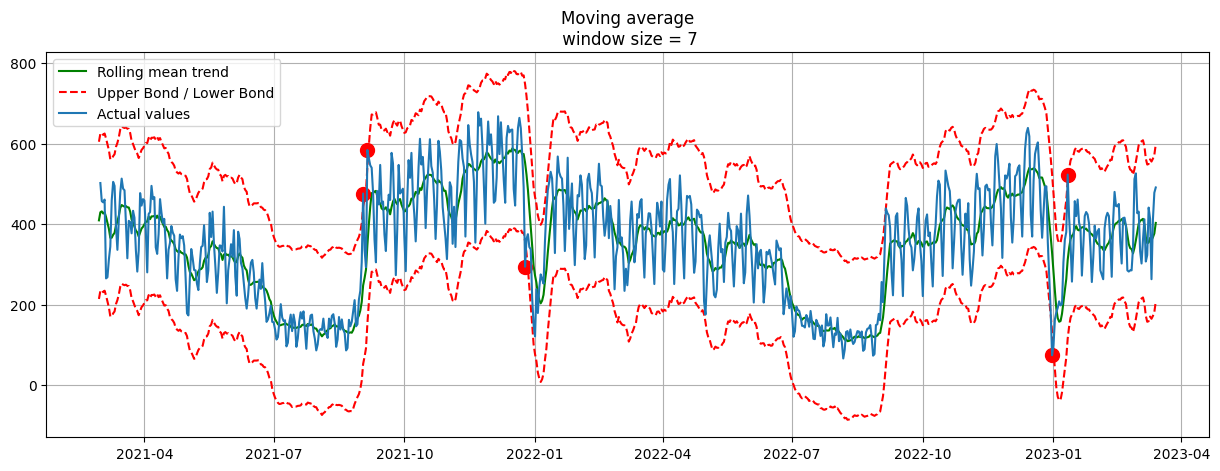

In [10]:
anomalies = plotMovingAverage(
    my_data.set_index('Date'), 7, plot_intervals=True, plot_anomalies=True
)  # daily smoothing

In [11]:
anomalies[anomalies.Views.notna()]

Views
Date             
2021-09-02  476.0
2021-09-05  584.0
2021-12-25  294.0
2022-12-31   74.0
2023-01-11  523.0

Я бы не сказал, что в данных есть выбросы. Ничего менять в данных не будем)

### Приведение ряда к стационарному виду

In [12]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

Сначала рассмотрим декомпозицию ряда

Критерий Дики-Фуллера: p=0.222164


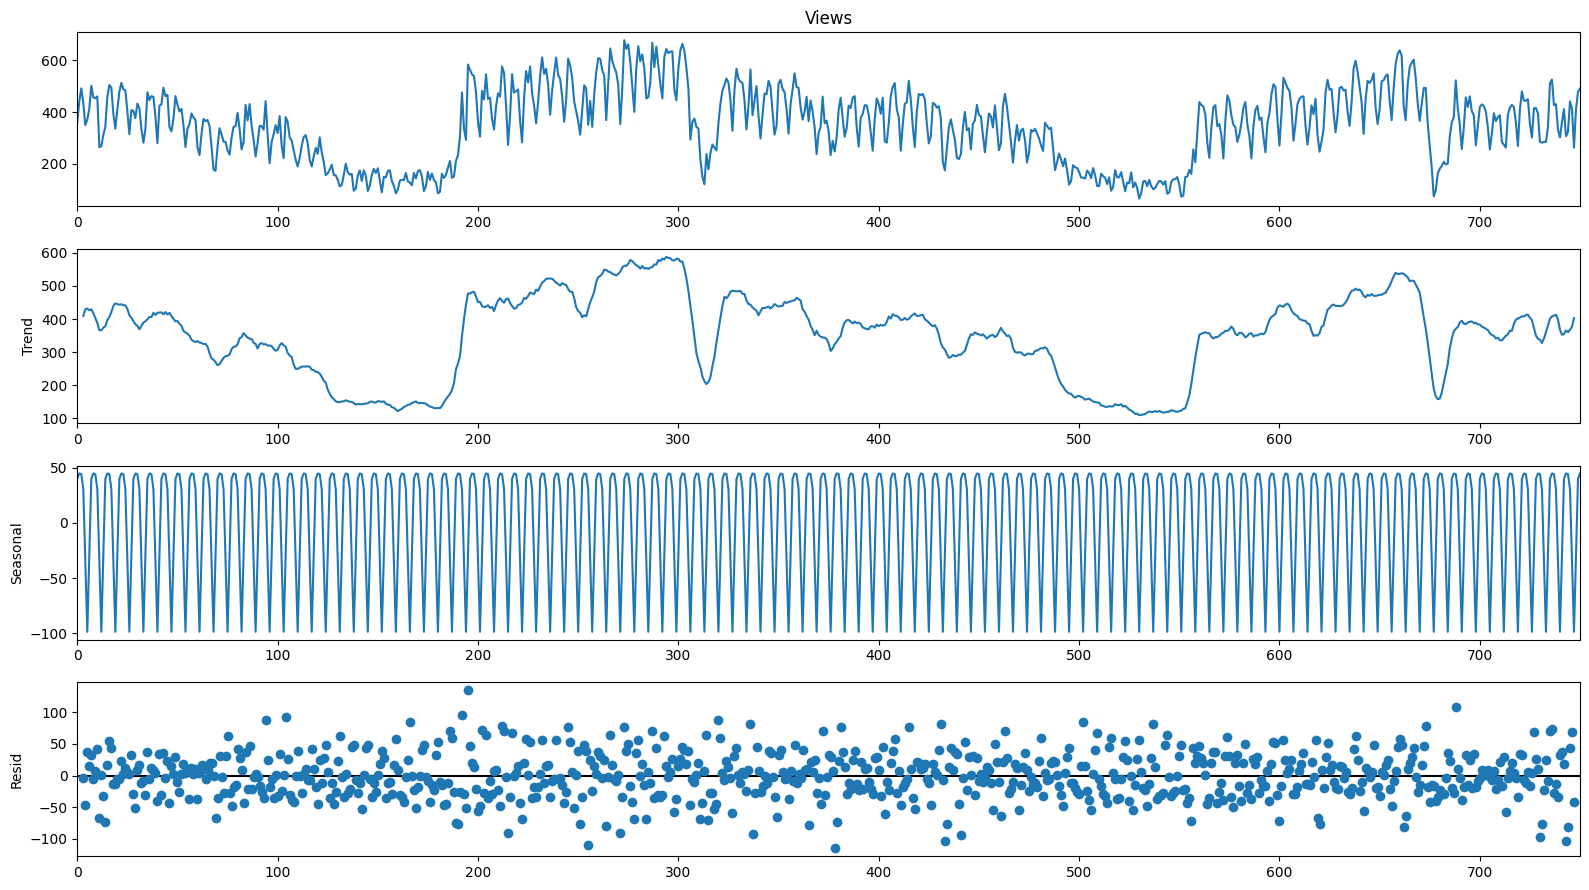

In [13]:
def decomposition(ts, period):
    decomp_viz = sm.tsa.seasonal_decompose(ts, period=period)
    fig = decomp_viz.plot()
    fig.set_size_inches((16, 9))
    fig.tight_layout()
    plt.show()
    
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(my_data['Views'])[1])
decomposition(my_data['Views'], period=7)

Декомпозиция - разложения ряда на 3 компоненты:
1. Тренд - плавное долгосрочное изменение временного ряда
2. Сезонность - циклические изменения временного ряда с постоянным периодом сезонности s
3. Ошибка - непрогнозируемая случаемая величина

В широком смысле, ряд стационарен, если:
1. Дисперсия не зависит от времени (колебания не растут со временем)
2. Математическое ожидание не зависит от времени (в среднем значение ряда постоянно)
3. Корреляция между a и b такая же, как и между a+t и b+t

**Ряд не стационарен**, потому что: 
1. Не выполняется критерий дики-фуллера. 
2. Есть тренд (возрастает и убывает)
3. Наличие сезонности в 7 дней (смотреть ниже)

**Вопрос к преподавателю.** Компонента разложения 'сезонность' может и не отображать сезонность как таковую? На лекции [МФТИ](https://www.youtube.com/watch?v=u433nrxdf5k) услышал, что циклы (а ведь они могут отображаться в компоненте "сезонность") не являются признаком нестационарности.

Я правильно понимаю, что сезонность проявляется в коррелограмме?

In [14]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

Критерий Дики-Фуллера: p=0.222164


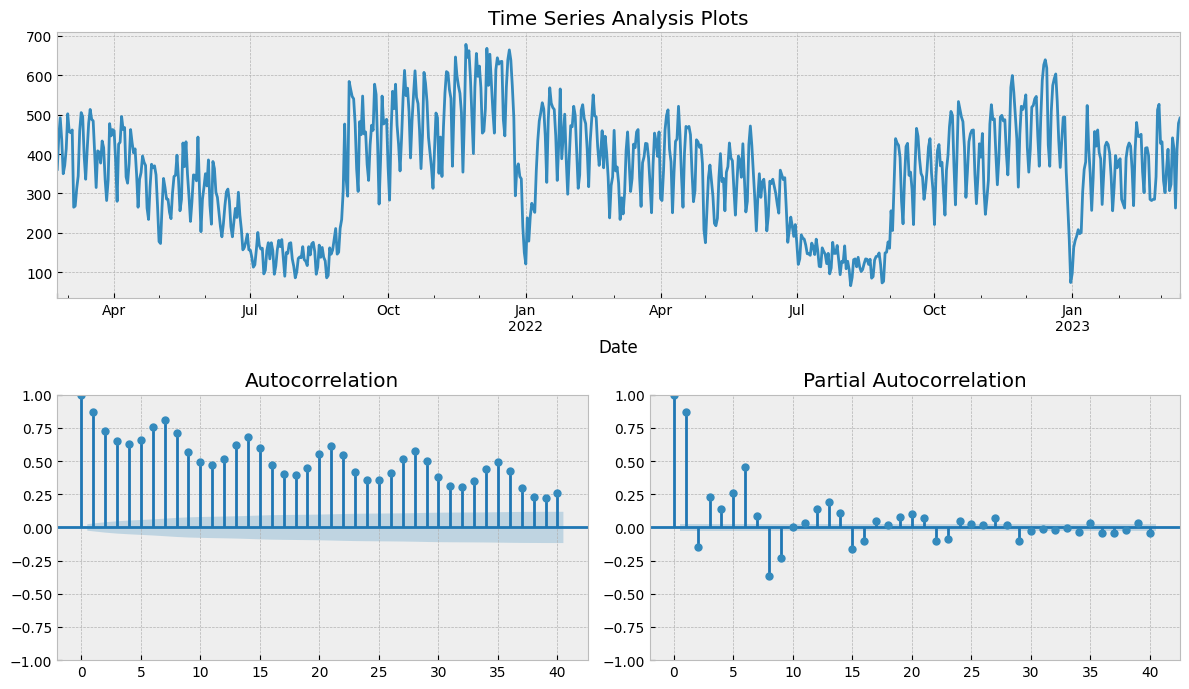

In [15]:
tsplot(my_data.set_index('Date').Views, lags=40)

Вот здесь и проявилась наша сезонность на графике коррелограммы (автокорреляции)

Также мы получаем слишком много значащих лагов. Попробуем привести ряд к стационарности

In [16]:
from copy import deepcopy
data = deepcopy(my_data)

#### Стабилизация дисперсии

Дисперия вроде не зависит от времени, но лучше все равно попробовать её стабилизировать

Оптимальный параметр преобразования Бокса-Кокса: 0.9140862997090538
Критерий Дики-Фуллера: p=0.223182


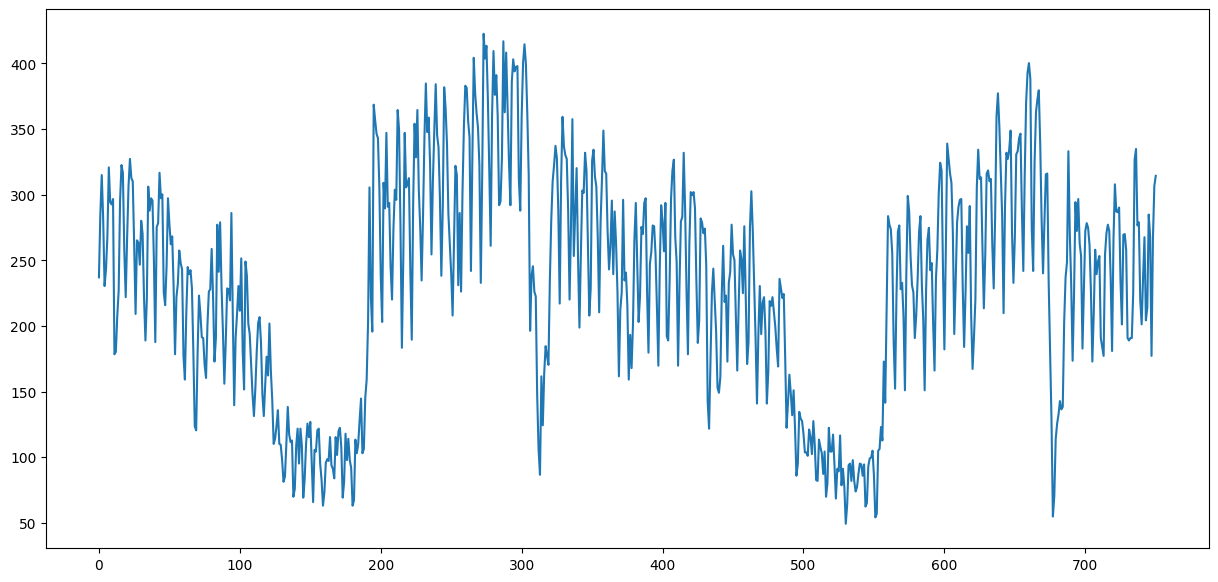

In [17]:
from scipy import stats
import statsmodels.api as sm
data['Box'], lambda_ = stats.boxcox(data.set_index('Date').Views)
plt.figure(figsize=(15,7))
plt.plot(data.Box)
print(f"Оптимальный параметр преобразования Бокса-Кокса: {lambda_}")
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Box)[1])

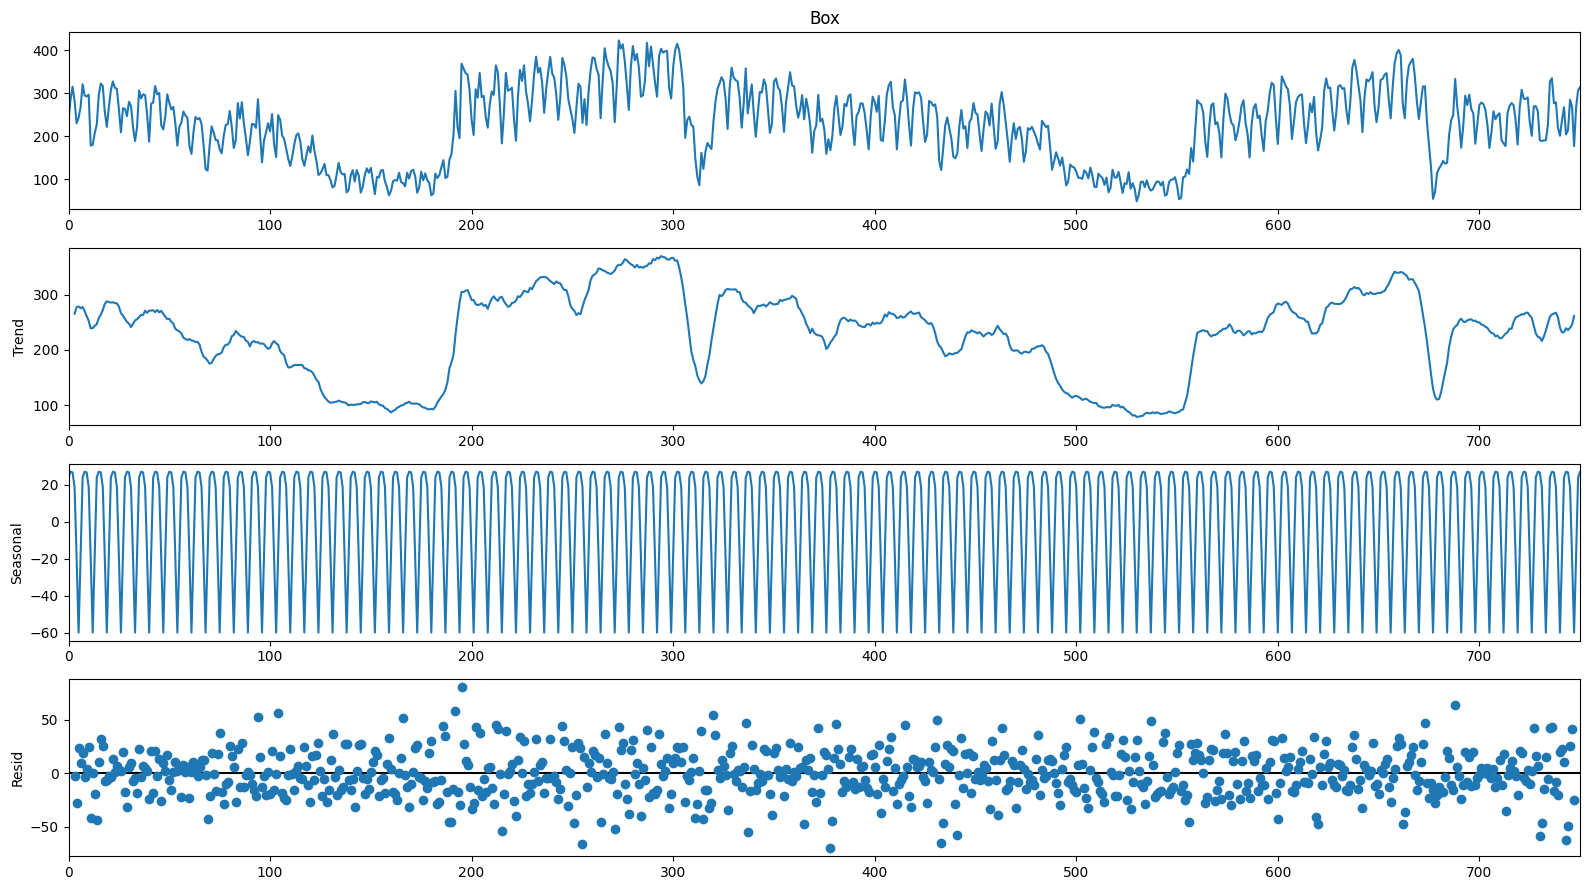

In [18]:
decomposition(data['Box'], period=7)

Кажется лучше не стало, поэтому не будем изменять ряд

##### Дифференцирование сезонности & тренда

Уберем сезонность. Для этого вычтем ряд из самого себя с "лагом", равным сезонному периоду (7).

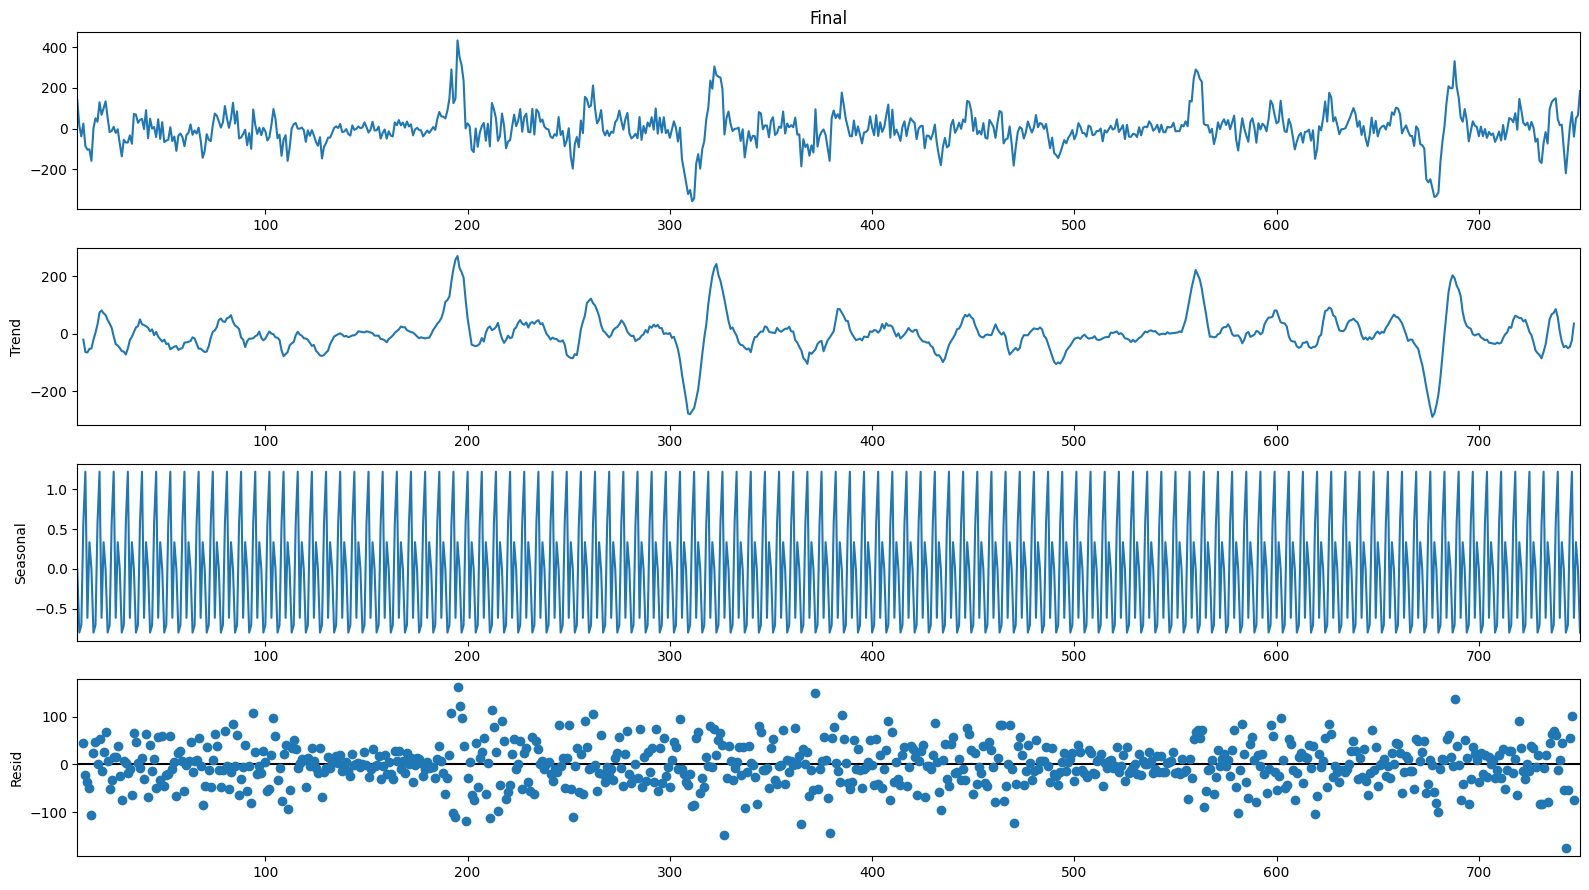

In [19]:
s = 7
data['Final'] = data.Views - data.Views.shift(s)
decomposition(data.Final[s:], period=7)

Критерий Дики-Фуллера: p=0.000000


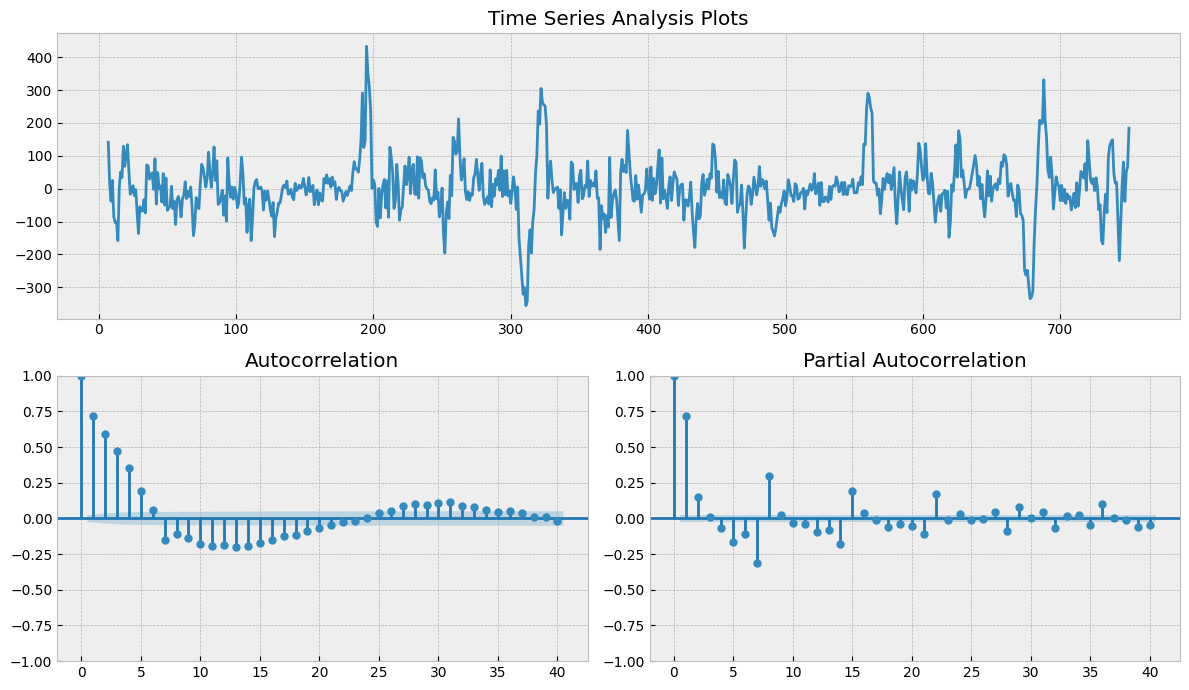

In [20]:
tsplot(data.Final[s:], lags=40)

Исчезла видимая сезонность. Однако на графике корреляции по-прежнему слишком много значимых лагов. Попробуем убрать их, вычтев ряд из себя с лагом 1.

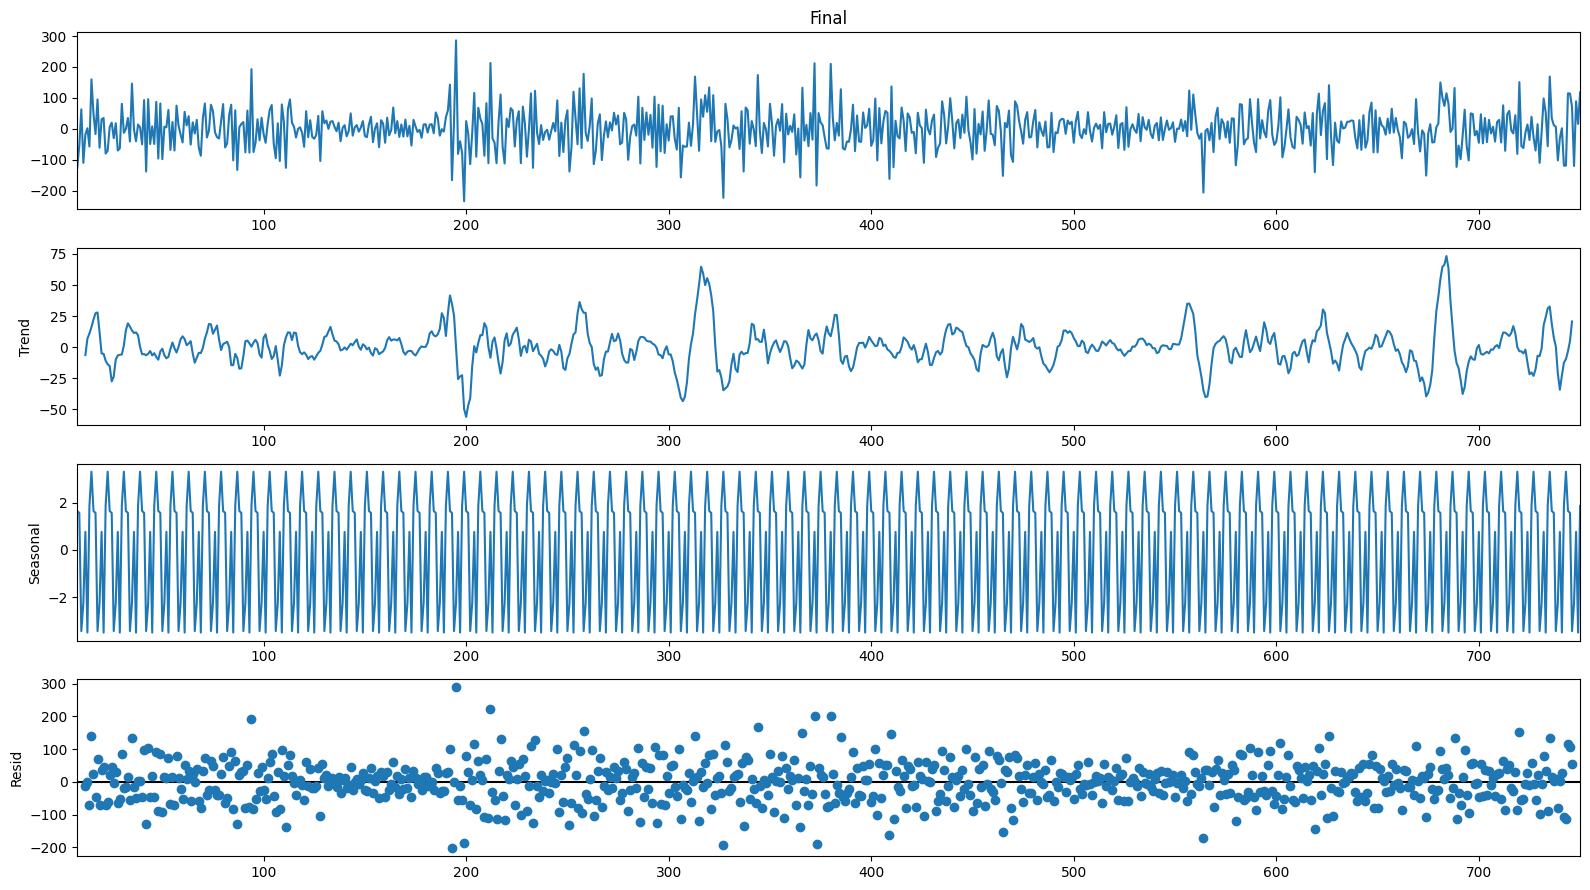

In [21]:
s_ = 1
s+=s_
data['Final'] = data.Final - data.Final.shift(s_)
decomposition(data.Final[s:], period=s)

Критерий Дики-Фуллера: p=0.000000


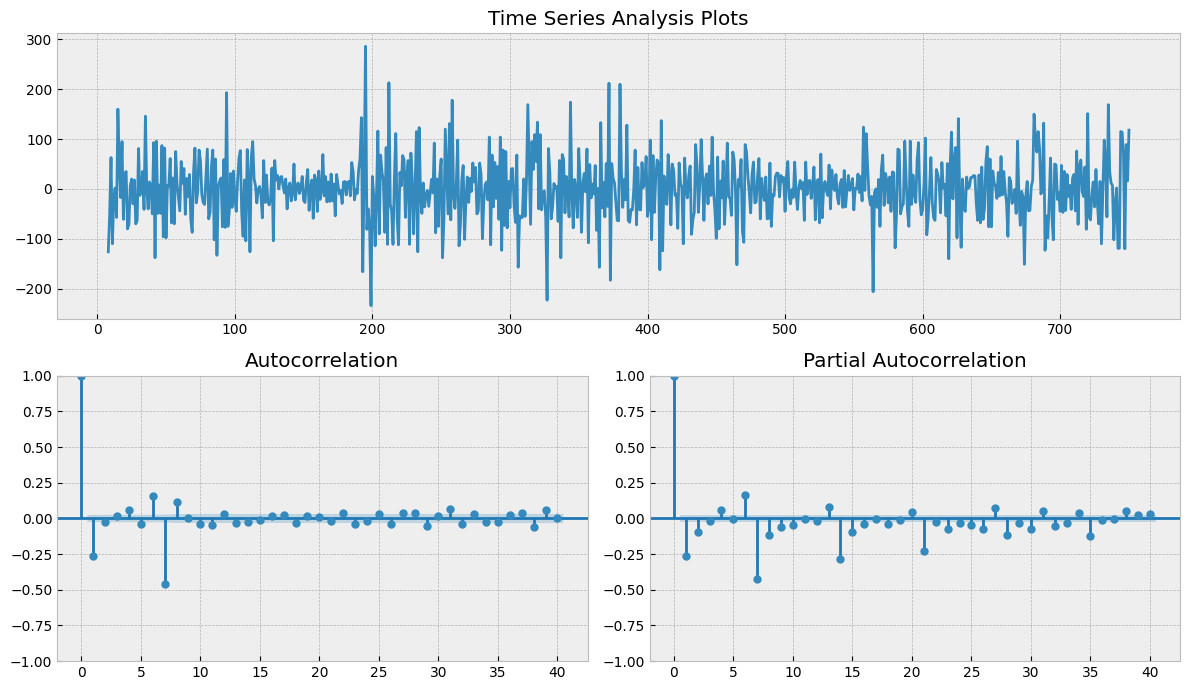

In [22]:
tsplot(data.Final[s:], lags=40)

Критерий Дики-Фуллера выполнен; тренд перестал возрастать (просто колеблется); мат.ожидание не меняется со временем; стало меньше значащих лагов в автокорреляции; убрали недельную сезонность => получили стационарный ряд

### Подбор параметров и обучение модели

Нам подойдет модель Sarima, так как есть сезонность

Критерий Дики-Фуллера: p=0.000000


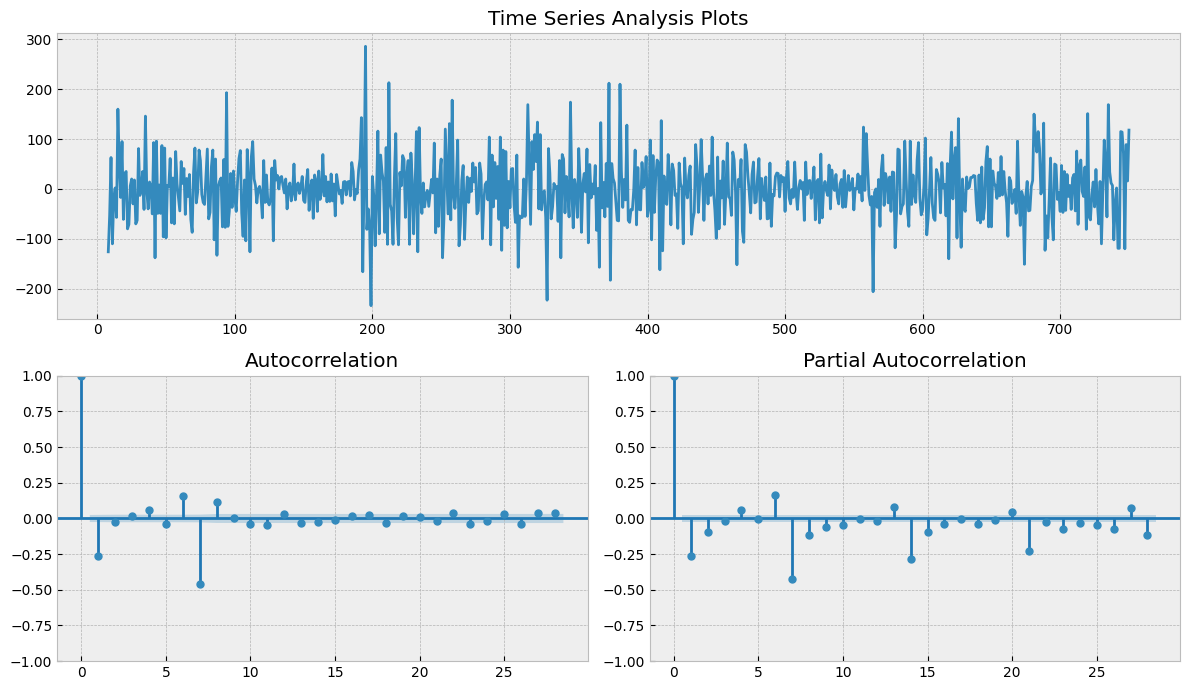

In [23]:
tsplot(data.Final[s:], lags=28)

По лекции ШАДа и [мфти](https://www.youtube.com/watch?v=u433nrxdf5k) выбирать надо так:

По графику автокорреляции:

Q - номер последнего значимого сезонного лага - (т.к 7)

q - номер последнего значимого несезонного лага - 8

По графику частичной автокорреляции:

P - аналогично 3 (т.к 28)

p - аналогично 26

s = 7, длина сезона

d = 1, порядок дифференцирования

D = 1

Однако в статьях, которые вы скидывали, строят графики, затем без обооснования берут какие-то странные начальные приближения и перебирают вокруг них параметры. Например, у них, условно, p мог быть равен 22 по графику, но они пишут, что он равен 3. В общем, я не понял этот момент и хотел бы получить фидбек.

Тогда попробую 3 подхода:
* Аналогичный ноутбуку, который Вы скинули
* Брать параметры по графику
* Ряд со стабилизированной дисперсией

#### Подход 1: аналогично ноутбуку

In [24]:
d = 1 
D = 1
s = 7
s_ = 7 + 1

In [25]:
ps = range(1, 4)
qs = range(1, 4)
Ps = range(0, 2)
Qs = range(0, 2)

In [26]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [27]:
%%time
import warnings
from tqdm import tqdm
results1 = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    #try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model=sm.tsa.statespace.SARIMAX(data['Views'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
    #print parameters on which the model is not trained and proceed to the next set
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    #save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results1.append([param, model.aic])

100%|███████████████████████████████████████████████████████████████████████████████████| 36/36 [01:12<00:00,  2.02s/it]

CPU times: user 2min 44s, sys: 2min 3s, total: 4min 47s
Wall time: 1min 12s


In [28]:
result_table1 = pd.DataFrame(results1)
result_table1.columns = ['parameters', 'aic']
print(result_table1.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
27  (3, 1, 1, 1)  7860.789466
7   (1, 2, 1, 1)  7861.084235
11  (1, 3, 1, 1)  7861.320816
23  (2, 3, 1, 1)  7861.924150
15  (2, 1, 1, 1)  7863.069884


In [29]:
p, q, P, Q = result_table1.parameters[0]

In [30]:
best_model1=sm.tsa.statespace.SARIMAX(data['Views'], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Views   No. Observations:                  751
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 7)   Log Likelihood               -4114.321
Date:                            Mon, 27 Mar 2023   AIC                           8234.641
Time:                                    07:17:30   BIC                           8248.473
Sample:                                         0   HQIC                          8239.973
                                            - 751                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0024      0.115      0.021      0.983      -0.223       0.227
ma.L1         -0.2955      0.108   

Критерий Стьюдента: p=0.961960
Критерий Дики-Фуллера: p=0.000000


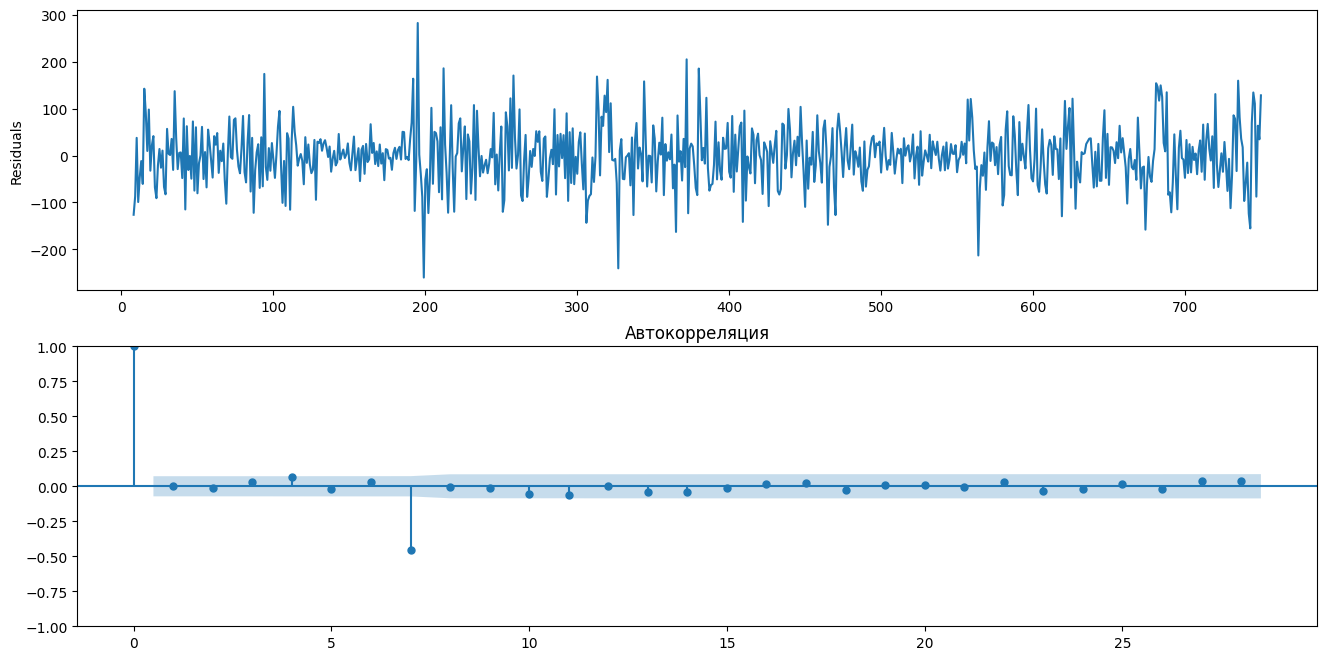

In [58]:
plt.figure(figsize=(16,8))
plt.subplot(211)
best_model1.resid[s_:].plot() 
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model1.resid[s_:].values.squeeze(), ax=ax, title='Автокорреляция', lags=28)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model1.resid[s:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model1.resid[s_:])[1])

Чтобы понять, хороша ли модель, надо посмотреть на остатки (разность между фактом и прогнозом). Они должны быть: 
* не смещены по критерию Стьюдента
* стационарны по критерию Дики-Фуллера 
* неавтокоррелированы (надо проверять по критерию Ljung-Box, но не нашел толкового объяснения)

К сожалению, остатки смещены. 2 и 3 пункт выполняются

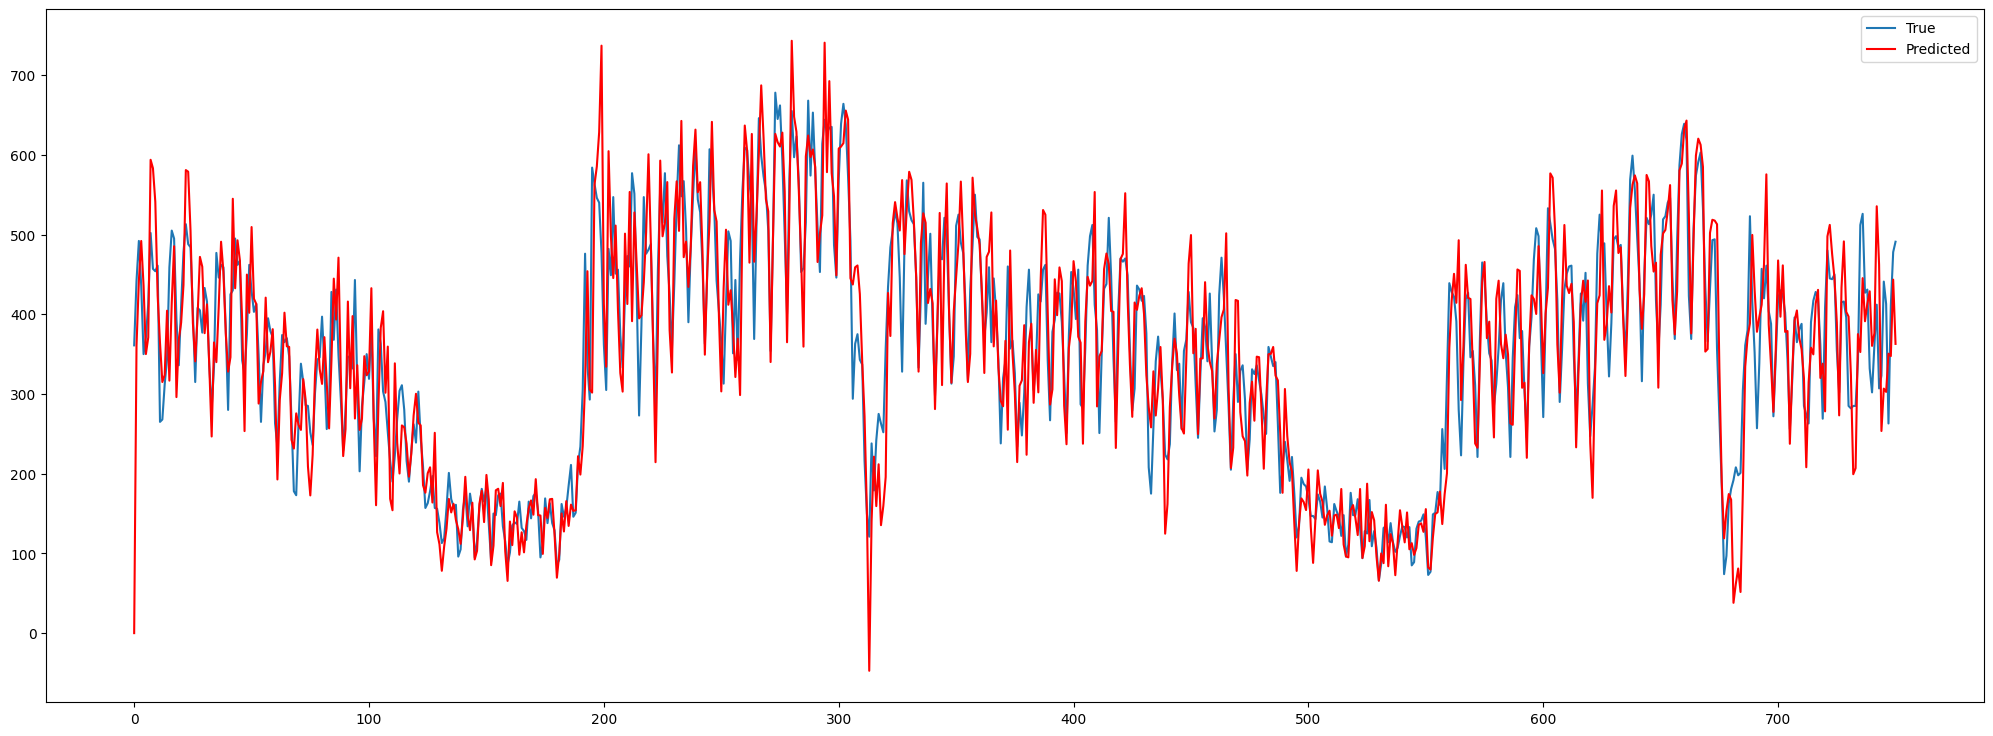

In [59]:
data['Pred'] = best_model1.fittedvalues
plt.figure(figsize=(25,9))
data['Views'].plot(label='True')
data.Pred.plot(color='r', label='Predicted')
plt.legend()
plt.show()

In [60]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_predictions(df, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted model
        n_steps - number of steps to predict in the future
    """
    data = df.copy()
    data.columns = ['Views']
    data['arima_model'] = model.fittedvalues

    # forecast values
    data['arima_model'][:s+d] = np.NaN
    forecast = data['arima_model'].append(model.forecast(n_steps))

    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['Views'][s+d:-n_steps], data['arima_model'][s+d:-n_steps])

    plt.figure(figsize=(20, 10))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="Predicted")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.Views, label="True", alpha=0.8)
    plt.legend()
    plt.grid(True)

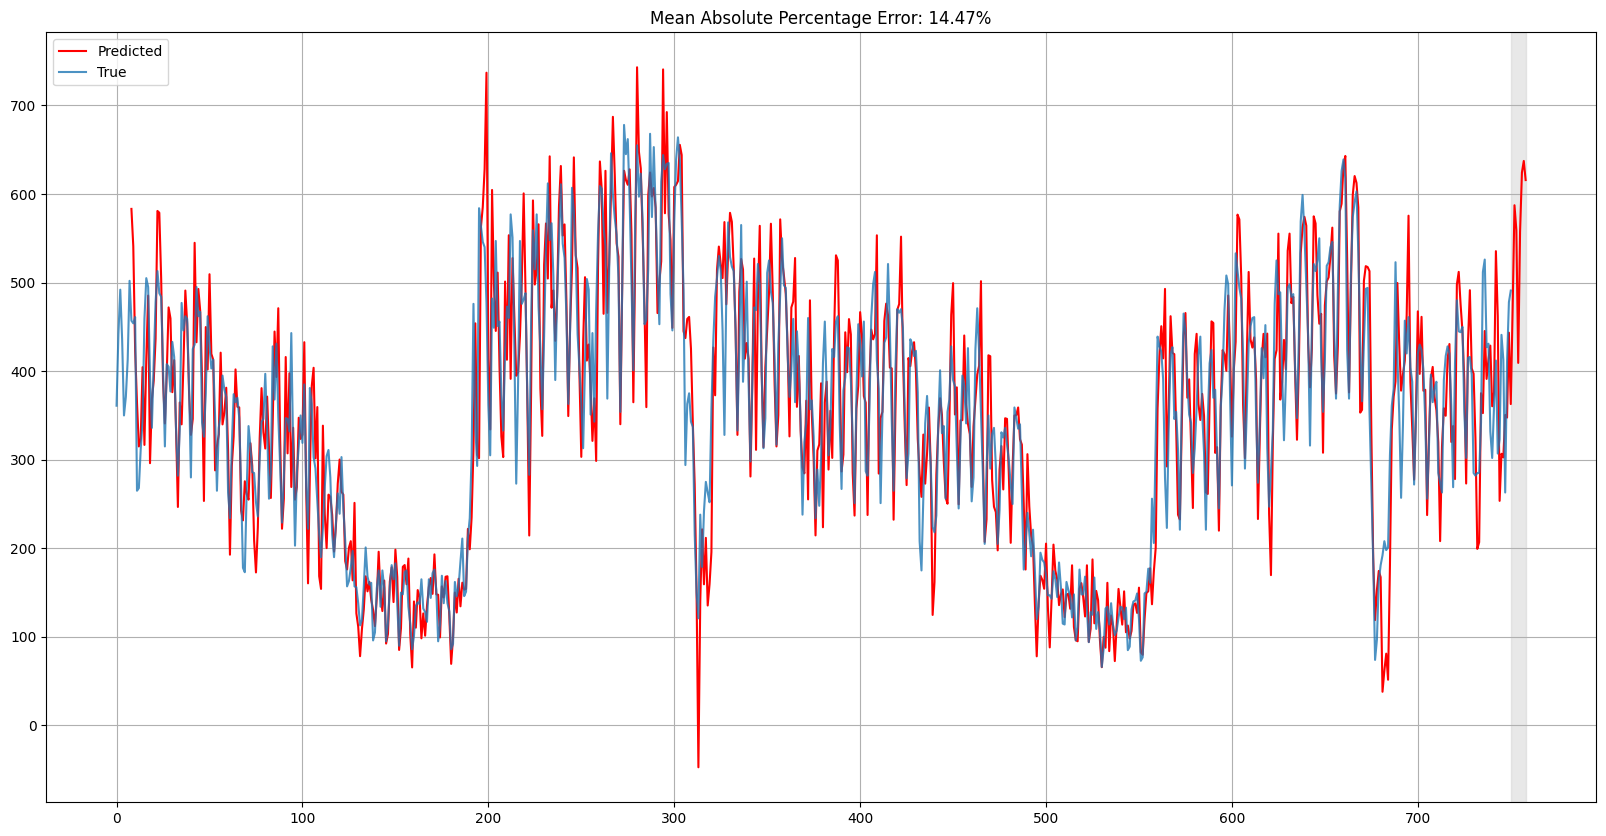

In [61]:
plot_predictions(data[['Views']], best_model1, s_)

#### Подход 2: гиперпараметры по графику

Повторим сказанное раннее:

По лекции ШАДа и [мфти](https://www.youtube.com/watch?v=u433nrxdf5k) выбирать надо так:

По графику автокорреляции:

Q - номер последнего значимого сезонного лага - 0 (т.к 7)

q - номер последнего значимого несезонного лага - 8

По графику частичной автокорреляции:

P - аналогично 3 (т.к 28)

p - аналогично 26

s = 7, длина сезона

d = 1, порядок дифференцирования

D = 1

Критерий Дики-Фуллера: p=0.000000


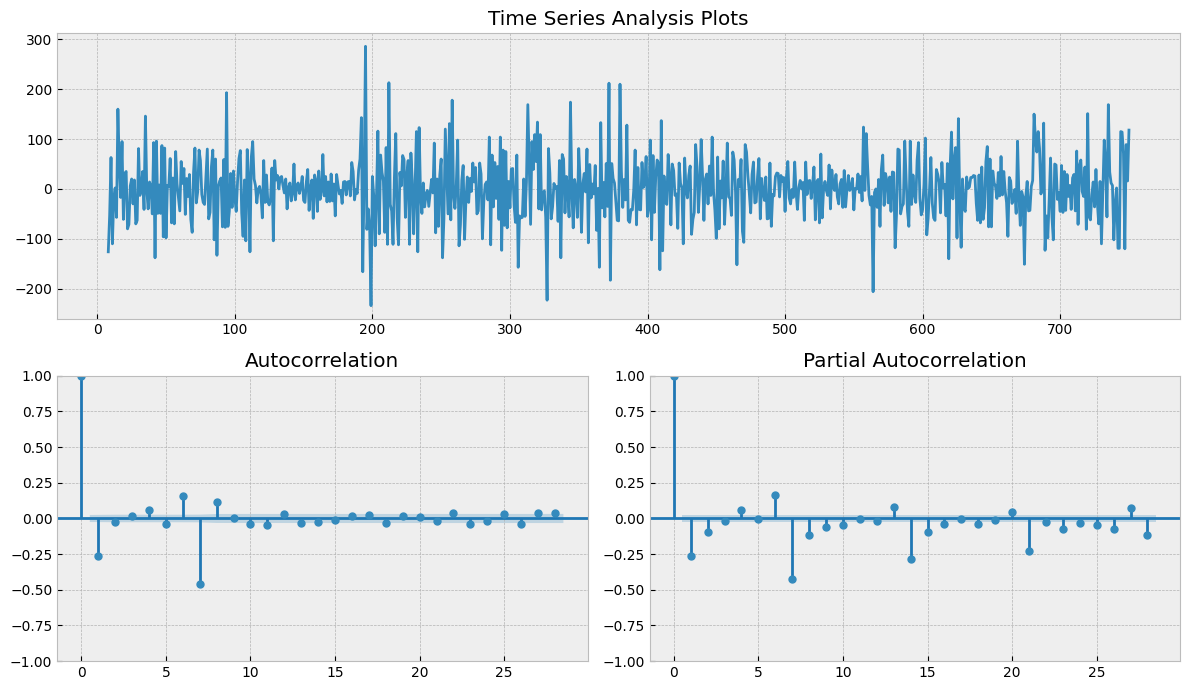

In [77]:
tsplot(data.Final[s:], lags=28)

In [62]:
d = 1 
D = 1
s = 7
s_ = 7 + 1

ps = range(24, 27)
qs = range(6, 10)
Ps = range(0, 4)
Qs = range(0, 2)

In [63]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

96

In [64]:
%%time
import warnings
from tqdm import tqdm
results2 = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    #try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model=sm.tsa.statespace.SARIMAX(data['Views'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
    #print parameters on which the model is not trained and proceed to the next set
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    #save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results2.append([param, model.aic])

100%|███████████████████████████████████████████████████████████████████████████████████| 96/96 [10:14<00:00,  6.40s/it]

CPU times: user 23min 44s, sys: 17min 9s, total: 40min 53s
Wall time: 10min 14s


In [65]:
result_table2 = pd.DataFrame(results2)
result_table2.columns = ['parameters', 'aic']
print(result_table2.sort_values(by = 'aic', ascending=True).head())

       parameters          aic
1   (24, 6, 0, 1)  7868.340715
11  (26, 6, 0, 1)  7871.356648
6   (25, 6, 0, 1)  7873.525542
12  (26, 7, 0, 0)  7878.517765
2   (24, 7, 0, 0)  7879.615367


In [66]:
p, q, P, Q = result_table2.parameters[0]
best_model2=sm.tsa.statespace.SARIMAX(data['Views'], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model2.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Views   No. Observations:                  751
Model:             SARIMAX(24, 1, 6)x(0, 1, [], 7)   Log Likelihood               -3923.356
Date:                             Mon, 27 Mar 2023   AIC                           7908.712
Time:                                     07:41:59   BIC                           8051.643
Sample:                                          0   HQIC                          7963.810
                                             - 751                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8627      1.068     -0.807      0.419      -2.957       1.231
ar.L2         -0.2878      

Критерий Стьюдента: p=0.934462
Критерий Дики-Фуллера: p=0.000000


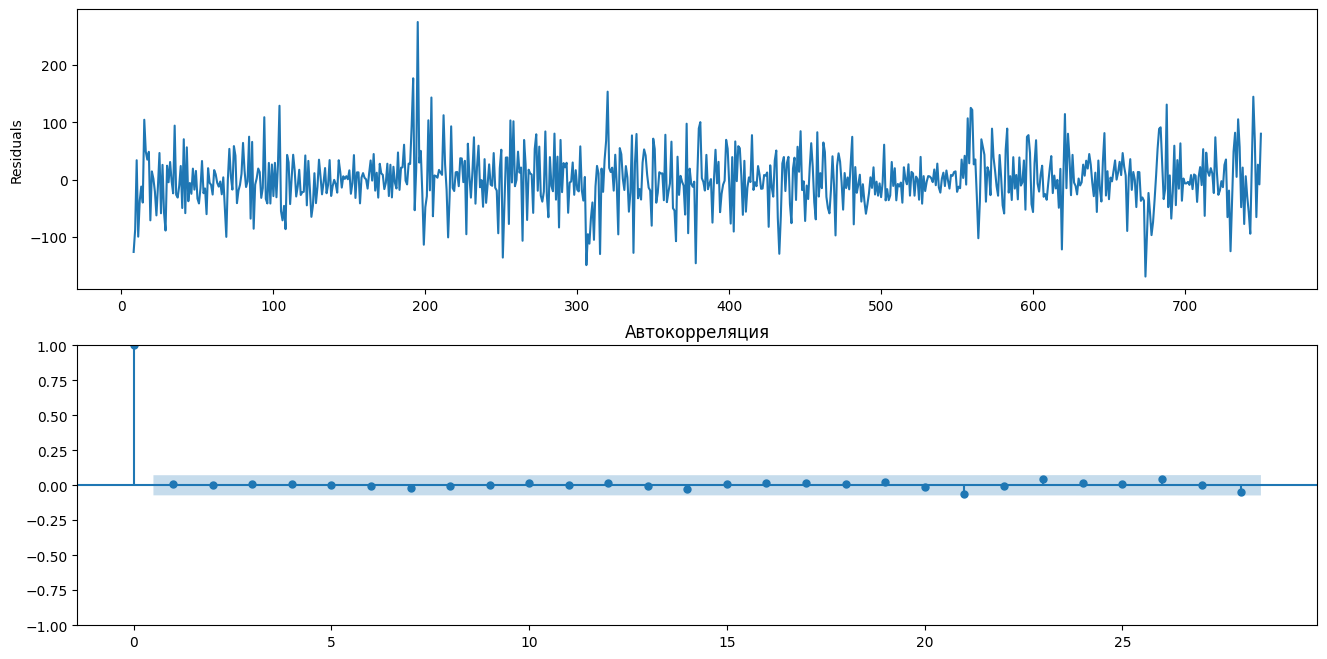

In [85]:
plt.figure(figsize=(16,8))
plt.subplot(211)
best_model2.resid[s_:].plot() 
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model2.resid[s_:].values.squeeze(), ax=ax, title='Автокорреляция', lags=28)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model2.resid[s:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model2.resid[s_:])[1])

К сожалению, остатки опять смещены.

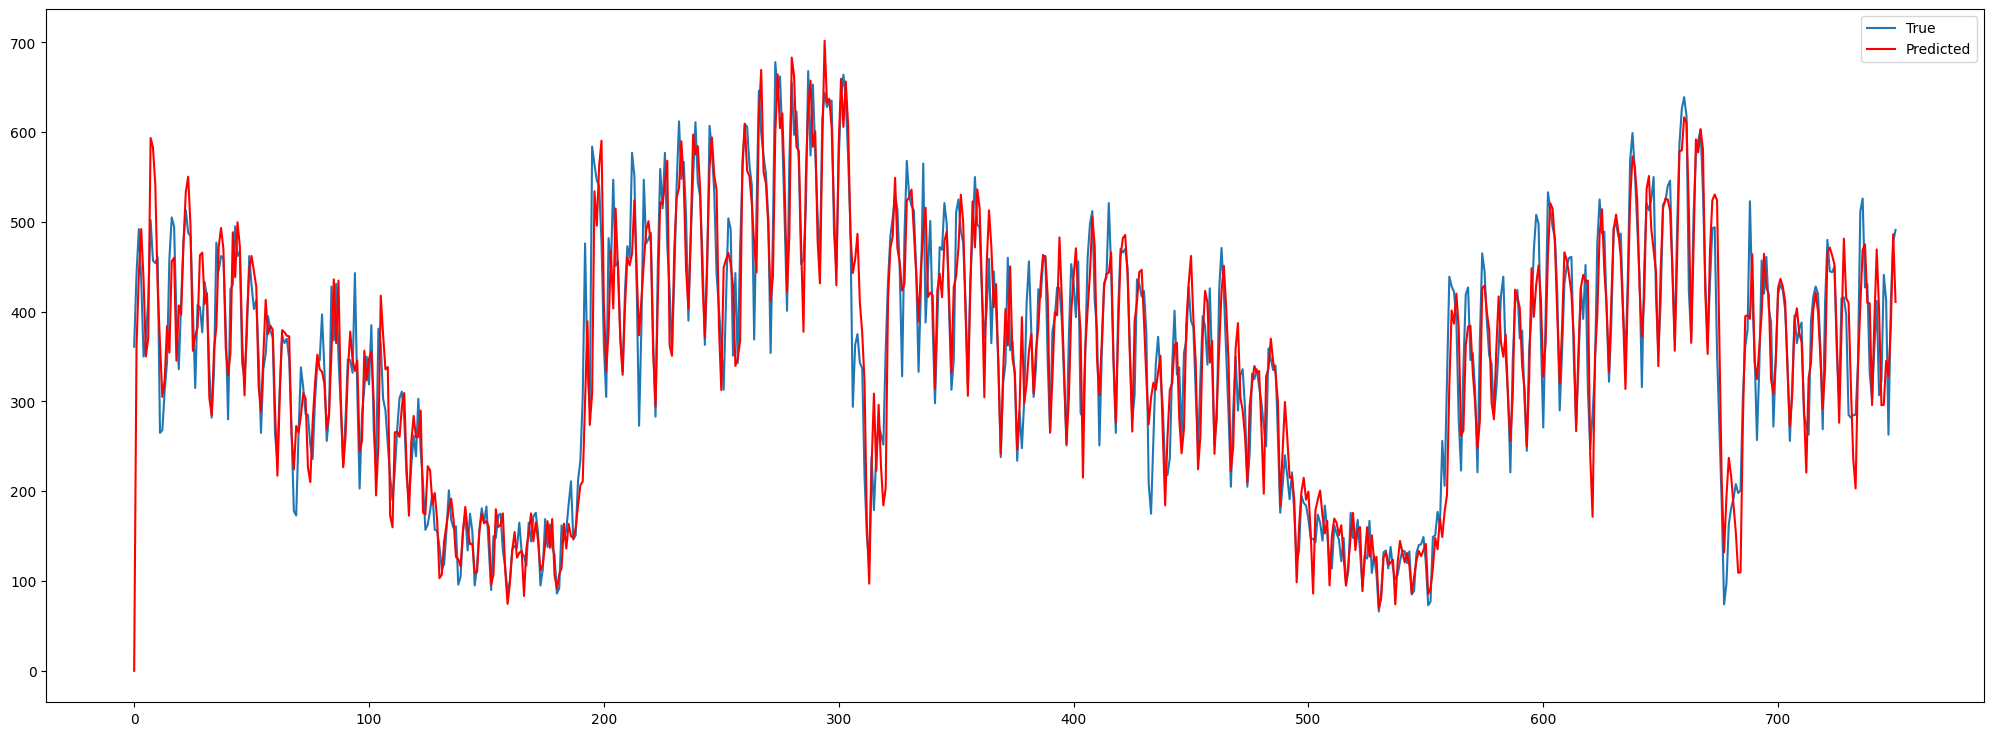

In [68]:
data['Predd'] = best_model2.fittedvalues
plt.figure(figsize=(25,9))
data['Views'].plot(label='True')
data.Predd.plot(color='r', label='Predicted')
plt.legend()
plt.show()

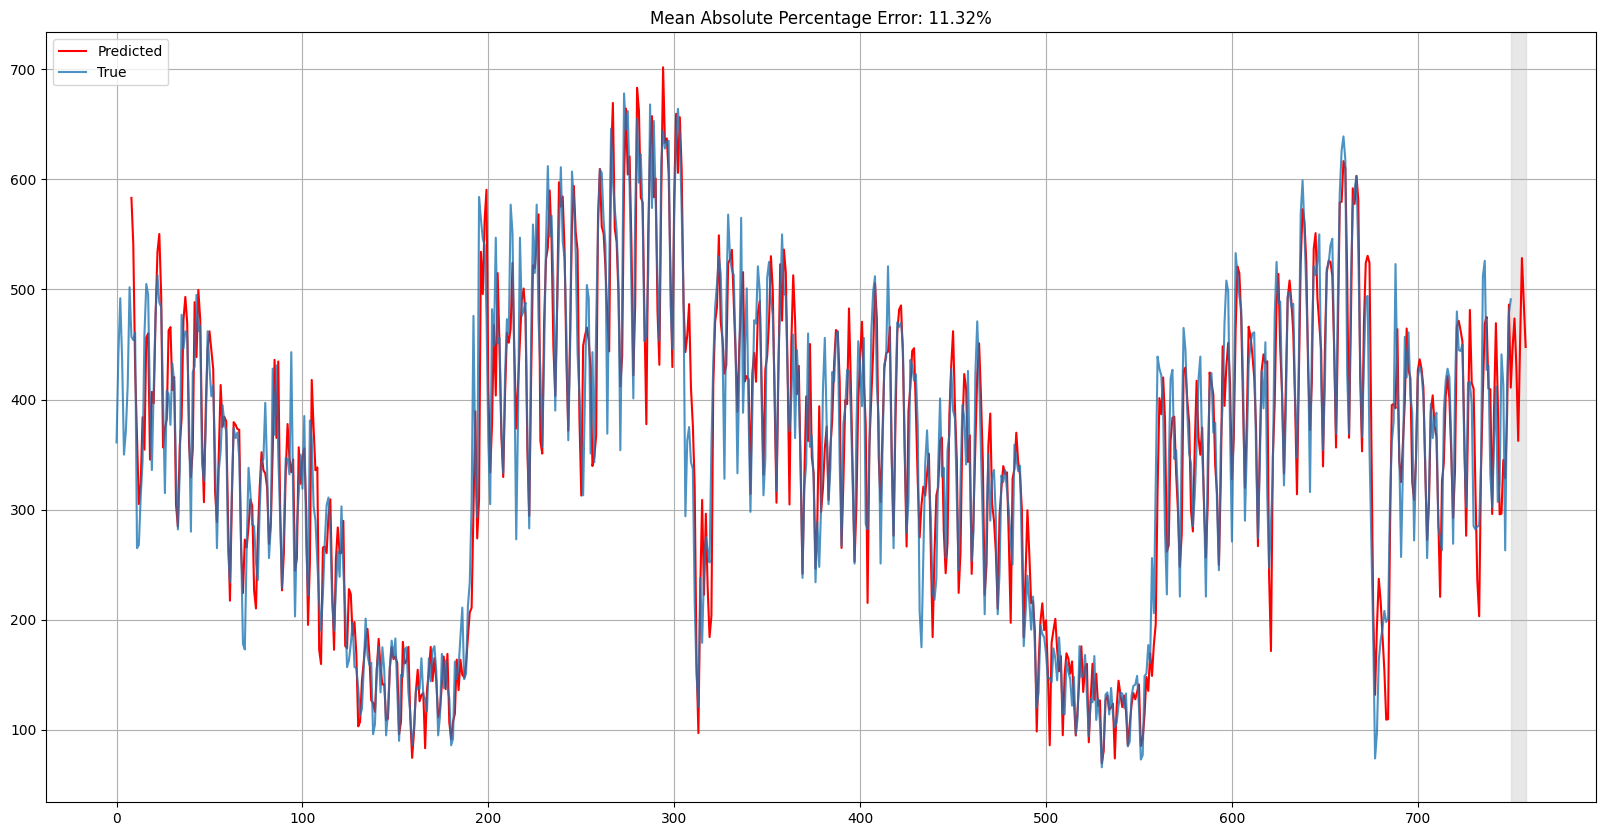

In [69]:
plot_predictions(data[['Views']], best_model2, s_)

#### Подход 3: стабилизированная дисперсия

In [72]:
data['Boxx'] = data.Box - data.Box.shift(7)
data['Boxx'] = data.Boxx - data.Boxx.shift(1)

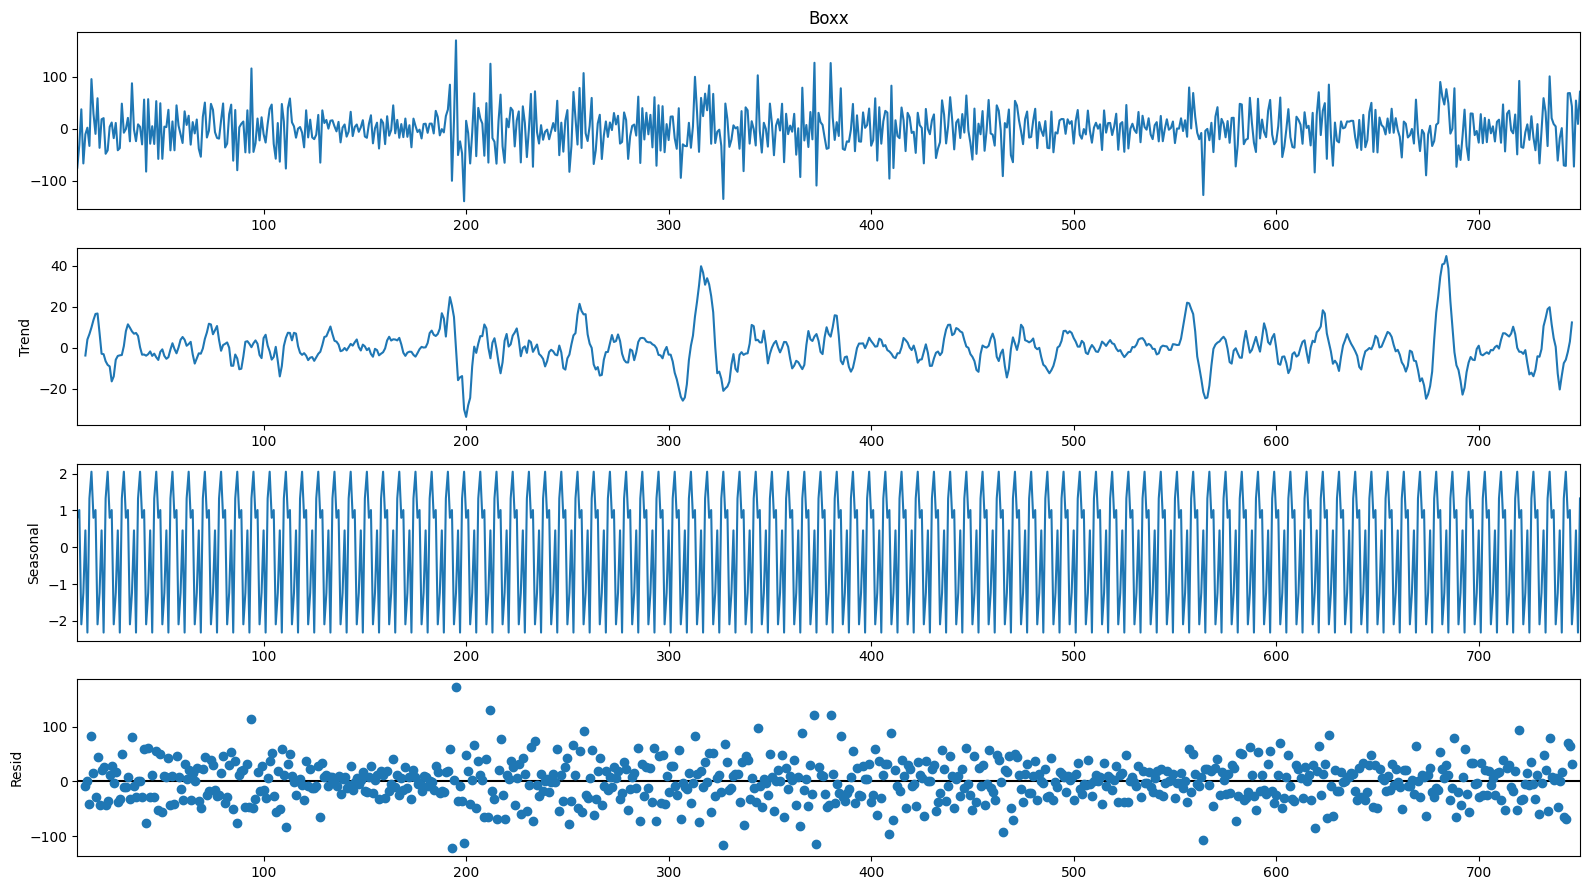

Критерий Дики-Фуллера: p=0.000000


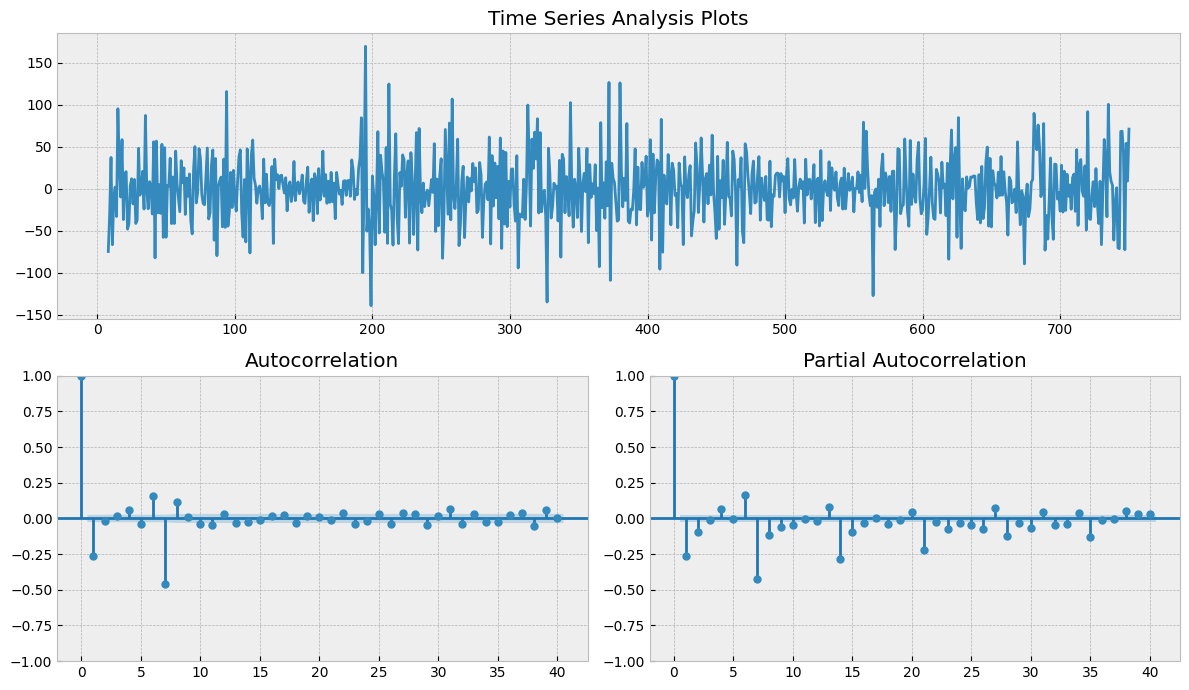

In [73]:
decomposition(data.Boxx[s_:], period=s_)
tsplot(data.Boxx[s_:], lags=40)

Аналогично тому как делали раннее

In [81]:
d = 1 
D = 1
s = 7
s_ = 7 + 1

ps = range(24, 27)
qs = range(5, 7)
Ps = range(0, 2)
Qs = range(0, 2)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

24

In [82]:
%%time
import warnings
from tqdm import tqdm
results3 = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    #try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model=sm.tsa.statespace.SARIMAX(data['Box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
    #print parameters on which the model is not trained and proceed to the next set
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    #save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results3.append([param, model.aic])

100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [10:28<00:00, 26.20s/it]

CPU times: user 23min 32s, sys: 18min 17s, total: 41min 50s
Wall time: 10min 28s


In [83]:
result_table3 = pd.DataFrame(results3)
result_table3.columns = ['parameters', 'aic']
print(result_table3.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
1  (24, 5, 0, 1)  7100.535920
5  (25, 5, 0, 1)  7100.781014
3  (24, 6, 0, 1)  7105.237897
9  (26, 5, 0, 1)  7105.963336
7  (25, 6, 0, 1)  7110.489093


In [84]:
p, q, P, Q = result_table3.parameters[0]
best_model3=sm.tsa.statespace.SARIMAX(data['Box'], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model3.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 Box   No. Observations:                  751
Model:             SARIMAX(24, 1, 5)x(0, 1, [], 7)   Log Likelihood               -3546.378
Date:                             Mon, 27 Mar 2023   AIC                           7152.756
Time:                                     08:15:01   BIC                           7291.076
Sample:                                          0   HQIC                          7206.077
                                             - 751                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8672      0.191     -4.540      0.000      -1.242      -0.493
ar.L2         -0.3434      

Критерий Стьюдента: p=0.937070
Критерий Дики-Фуллера: p=0.000000


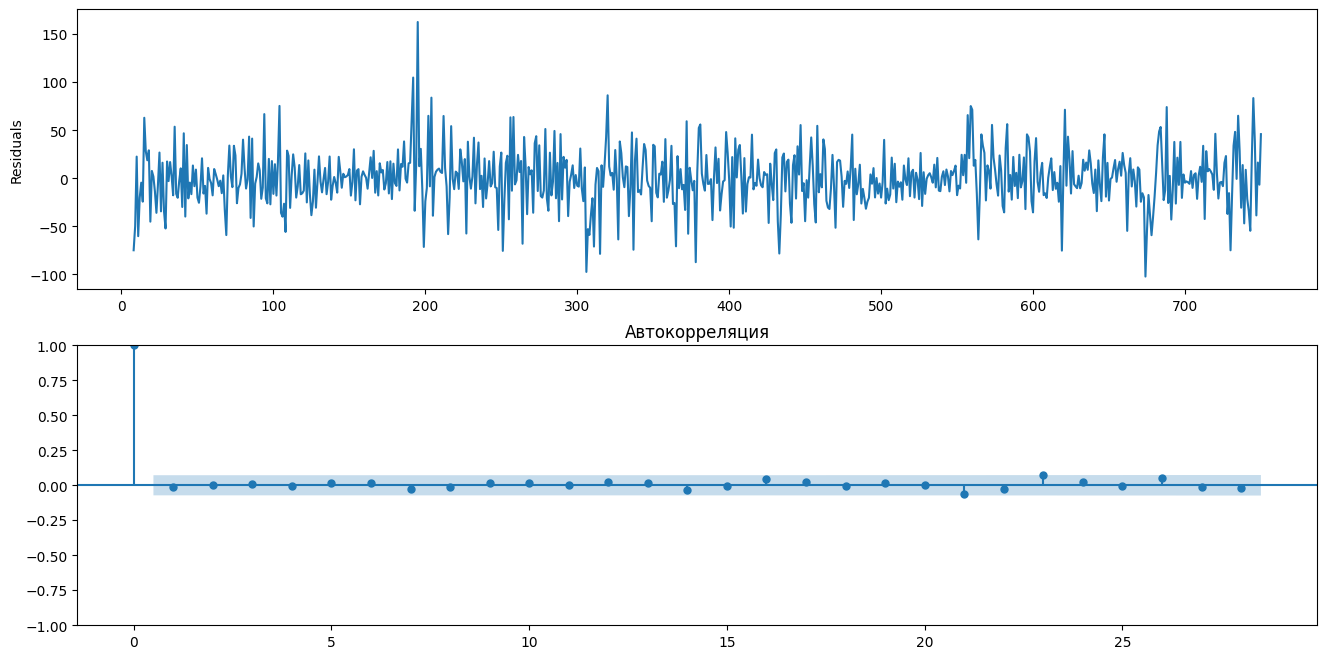

In [88]:
plt.figure(figsize=(16,8))
plt.subplot(211)
best_model3.resid[s_:].plot() 
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model3.resid[s_:].values.squeeze(), ax=ax, title='Автокорреляция', lags=28)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model3.resid[s:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model3.resid[s_:])[1])

In [90]:
def invboxcox(y,lmbda):
    # reverse Box Cox transformation
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

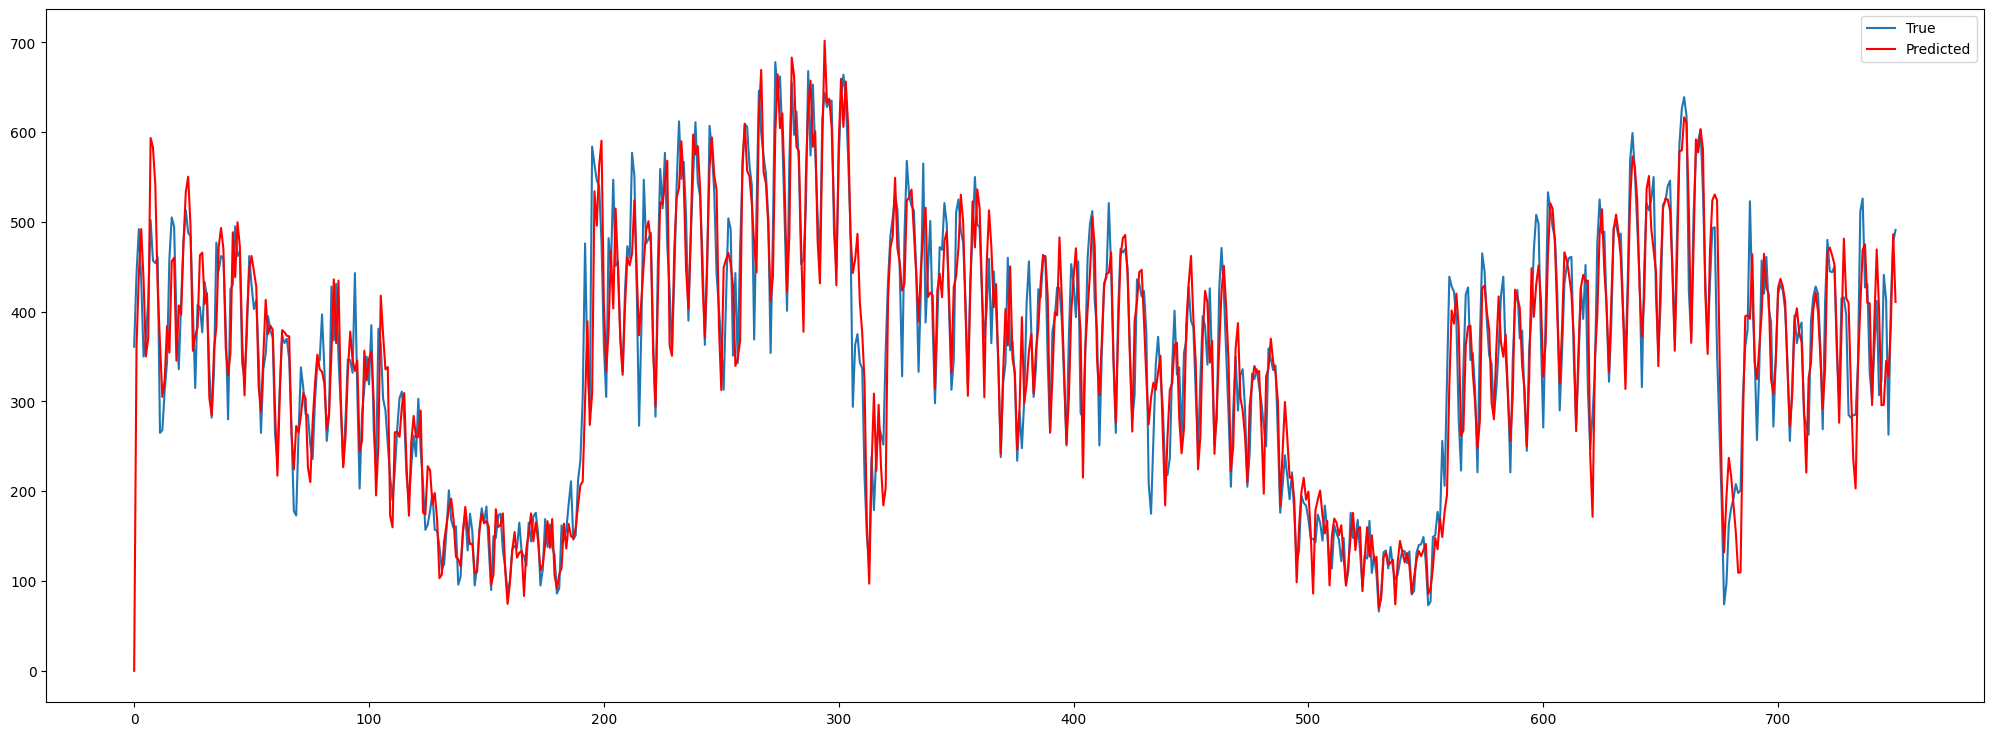

In [92]:
data['Preddd'] = invboxcox(best_model3.fittedvalues, lambda_)
plt.figure(figsize=(25,9))
data['Views'].plot(label='True')
data.Predd.plot(color='r', label='Predicted')
plt.legend()
plt.show()

In [93]:
def plot_predictions2(df, model, n_steps, lambda_):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted model
        n_steps - number of steps to predict in the future
    """
    data = df.copy()
    data.columns = ['Views']
    data['arima_model'] = invboxcox(model.fittedvalues, lambda_)

    # forecast values
    data['arima_model'][:s+d] = np.NaN
    forecast = data['arima_model'].append(model.forecast(n_steps))

    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['Views'][s+d:-n_steps], data['arima_model'][s+d:-n_steps])

    plt.figure(figsize=(20, 10))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="Predicted")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.Views, label="True", alpha=0.8)
    plt.legend()
    plt.grid(True)

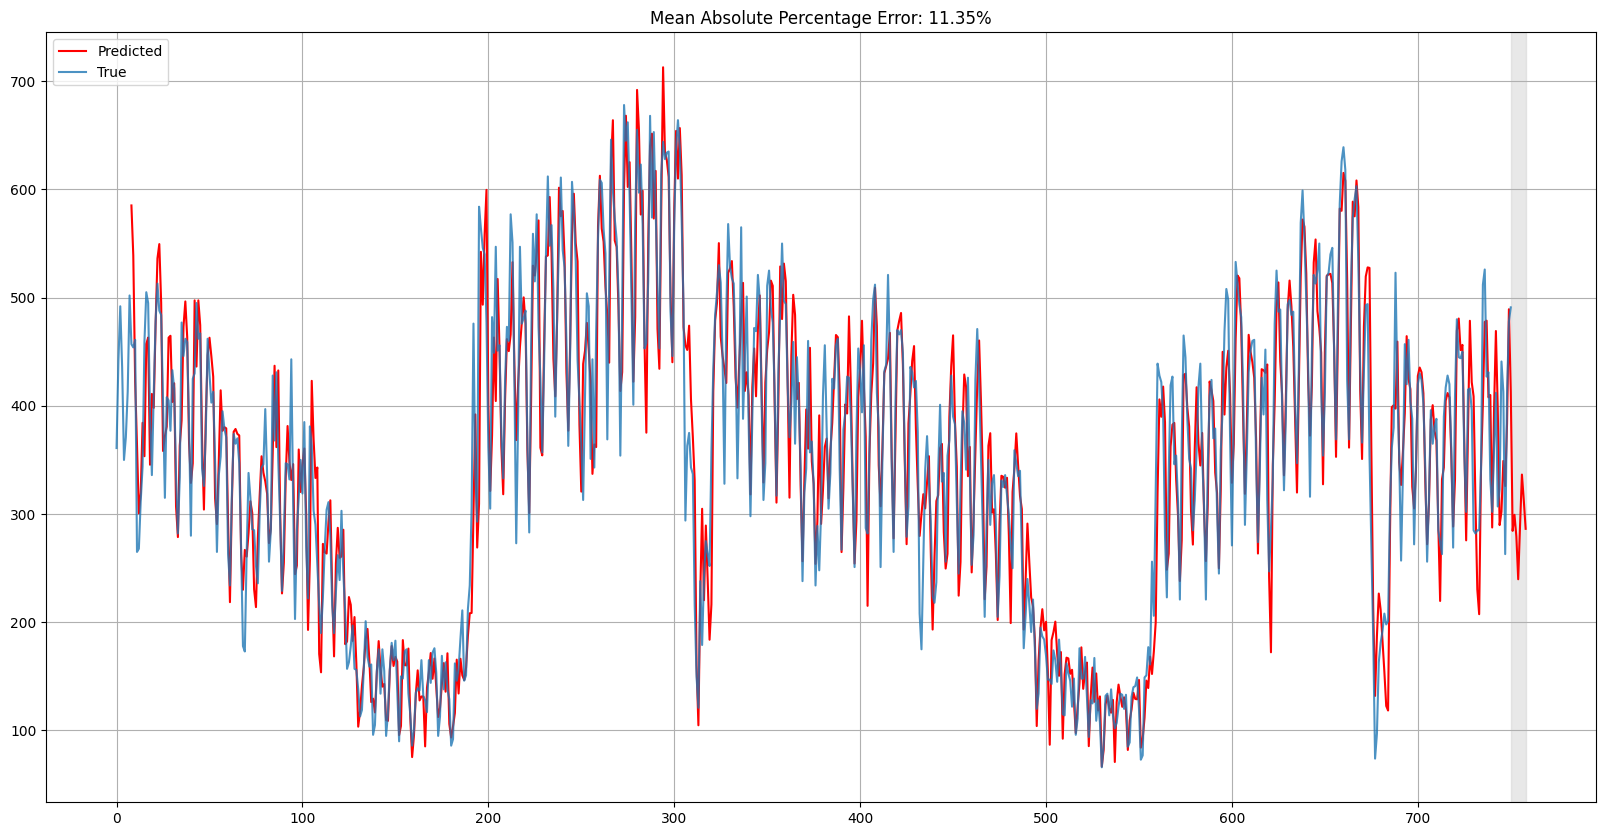

In [94]:
plot_predictions2(data[['Views']], best_model3, s_, lambda_)

## Overall

В итоге мы:
1. Загрузили ряд.
2. Проверили его аномалии.
3. Посмотрели на декомпозицию (разложение на тренд, сезонность и ошибку) и коррелограмму
4. Сделали ряд стационарным (убрали тренд и сезонность дифференцированием, стабилизировали дисперсию)
5. По графику подобрали начальные приближения p,q,P,Q
6. Вокруг этих параметров подобрали оптимальную модель SARIMA по AIC. При этом использовали 3 подхода к построению модели
7. Построили предсказания на 14 следующих дней. Ошибка MAPE на трейне - 11.32%
8. Чтобы полученная модель была хорошей, нужно выполнение следующих условий:

Остатки должны быть:
* не смещены по критерию Стьюдента
* стационарны по критерию Дики-Фуллера
* неавтокоррелированы (надо проверять по критерию Ljung-Box, но не нашел толкового объяснения)

Мы выполнили 2 и 3 условия, но ни одна из полученных мной моделей не прошла критерий Стьюдента :(